In [1]:
%reload_ext autoreload
%autoreload 2

import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

In [2]:
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

import serial
import matplotlib

dpe = DPE('COM6')
dpe.set_clock(50)

DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


Load various data
--

In [26]:
# Load the offline trained weights
# And the MNIST dataset
load_workspace(vars(), 'dataset/20190815-132601-weights')
load_workspace(vars(), 'dataset/mnist')

# Load the target conductane for linear correction
import scipy.io as sio
mat_contents = sio.loadmat('UpdatedGconv.mat')
finalGconv = mat_contents['finalGconv']

Loaded: weights, 
Loaded: train_images, train_labels, test_images, test_labels, 


Neural network model
--
Set the binarzation bits

In [27]:
nn = NN_dpe(weights)
dpe.N_BIT = 8

In [28]:
img_idx = 0

image = test_images[img_idx]
vectors = nn._conv_flattern(image)

# normalize
vectors /= np.abs(vectors).max()
output = dpe.multiply(1, vectors, c_sel=[0, 14], mode=0) / (nn.Gratio/2)
soft_output = (finalGconv.T @ vectors).T / (nn.Gratio/2)

In [29]:
lin_cor_conv = []
for c in range(14):
    lin_cor_conv.append( np.polyfit(output[:,c], soft_output[:,c], 1))

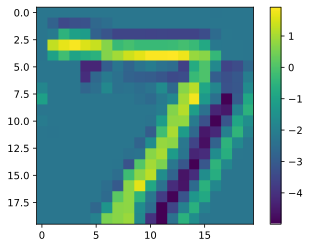

In [32]:
output_cor = dpe.lin_corr(output, lin_cor_conv)

# for c in range(14):
#     x = soft_output[:,c]
#     y = output_cor[:,c]
    
#     plt.plot(x,y,'.')
    
x = output_cor[:,::2] - output_cor[:,1::2]

x = x.reshape(20,20,-1)

plt.imshow(x[:,:,0])
plt.colorbar()

Software fully connected layer
--

In [33]:
x1 = nn.relu(x)
x1 = nn.max_pooling(x1)
x1 = nn.flattern(x1)
y = nn.dense(x1)

print(y)
print(y.argmax())

[ -5.51663411 -13.83934326  -5.43447467   0.21712136 -11.00212622
   5.57106374  -7.92903411  -3.3613175    4.07404318  -5.37711549]
5


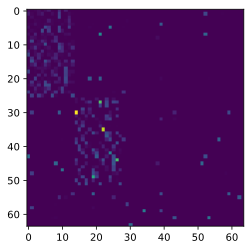

In [25]:
plt.imshow(dpe.read(1, method='slow'))

Accuracy test (experimental convolution)
--


In [ ]:
acc = []
i = 0

for label, img in zip(test_labels, test_images):
    
    vectors = nn._conv_flattern(img)
    
    # Convolution hardware call
    output = dpe.multiply(1, vectors, c_sel=[0, 14], mode=0) / (nn.Gratio/2)
    output_cor = dpe.lin_corr(output, lin_cor_conv)
    x = output_cor[:,::2] - output_cor[:,1::2]

    x = x.reshape(20,20,-1)
    
    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    
    # Software fully connect
    y = nn.dense(x1)
    
    acc.append( y.argmax() == label)
    
    display.clear_output(wait=True)
    
    # Plot
    fig = plt.figure(1)
    for ii in range(7):
        plt.subplot('33' + str(ii+1))
        plt.title('Channel #' + str(ii))
        plt.imshow(x[:,:,ii])
#         plt.colorbar()
    plt.tight_layout()
    display.display(fig)
    
    
    print(f'idx={i}, predicted: {y.argmax()}, label: {test_labels[i]}')
    acc.append( y.argmax() == test_labels[i] )
    print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')
    
    i += 1


For hardware dense (fully connect) layer, refer to 'testbench_wk5_4_prober2_unary' notebook
--